In [1]:
import csv

import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

RANDOM_SEED = 42

In [13]:
dataset = 'Data_joren.csv'
dataset_test = 'glove_test_data.csv'
#model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
#tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'
model_save_path = 'new_datahand_classifier.hdf5'
tflite_save_path = 'new_datahand_classifier.tflite'

In [14]:
NUM_CLASSES = 24

In [15]:
arr = pd.read_csv(dataset, header=None, delimiter=";")
# check the shape
input_shape = arr.shape
print(arr.iloc[0])
print(arr.iloc[1])
print(f"The input shape of your array is: {input_shape}")

0    0,0,0,0,3.519914,0.050033,3.621713,6.846703,-2...
Name: 0, dtype: object
0    0,0,0,0,3.519914,0.050033,3.621713,6.847597,-2...
Name: 1, dtype: object
The input shape of your array is: (8400, 1)


In [70]:
#X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, 365)))
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(300, 325)) + list(range(4, 151)))
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))
X_train, X_validation, y_train, y_validation = train_test_split(X_dataset, y_dataset, train_size=0.70, random_state=RANDOM_SEED)
#X_test, X_validation, y_test, y_validation = train_test_split(X, y, train_size=0.70, random_state=RANDOM_SEED)
X_test = np.loadtxt(dataset_test, delimiter=',', dtype='float32', usecols=list(range(300, 325)) + list(range(4, 151)))
y_test = np.loadtxt(dataset_test, delimiter=',', dtype='int32', usecols=(0))

In [71]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((172, 1), input_shape=(172,)),
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [72]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((172, 1), input_shape=(172,)),
    tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [73]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((172, 1), input_shape=(172,)),
    tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Reshape((21, 128, 1)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [74]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_12 (Reshape)        (None, 172, 1)            0         
                                                                 
 conv1d_27 (Conv1D)          (None, 172, 32)           128       
                                                                 
 max_pooling1d_27 (MaxPooli  (None, 86, 32)            0         
 ng1D)                                                           
                                                                 
 conv1d_28 (Conv1D)          (None, 86, 64)            6208      
                                                                 
 max_pooling1d_28 (MaxPooli  (None, 43, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_29 (Conv1D)          (None, 43, 128)         

In [75]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [76]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [77]:
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_validation, y_validation),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
46/46 [==============================] - ETA: 0s - loss: 2.8838 - accuracy: 0.1609
Epoch 1: saving model to new_datahand_classifier.hdf5
46/46 [==============================] - 17s 334ms/step - loss: 2.8838 - accuracy: 0.1609 - val_loss: 1.5525 - val_accuracy: 0.5183
Epoch 2/1000


C:\gesture_recognition_by_image\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - ETA: 0s - loss: 1.2249 - accuracy: 0.5696
Epoch 2: saving model to new_datahand_classifier.hdf5
46/46 [==============================] - 15s 331ms/step - loss: 1.2249 - accuracy: 0.5696 - val_loss: 0.4686 - val_accuracy: 0.8266
Epoch 3/1000
46/46 [==============================] - ETA: 0s - loss: 0.5343 - accuracy: 0.8068
Epoch 3: saving model to new_datahand_classifier.hdf5
46/46 [==============================] - 16s 345ms/step - loss: 0.5343 - accuracy: 0.8068 - val_loss: 0.1754 - val_accuracy: 0.9488
Epoch 4/1000
46/46 [==============================] - ETA: 0s - loss: 0.2795 - accuracy: 0.8966
Epoch 4: saving model to new_datahand_classifier.hdf5
46/46 [==============================] - 16s 338ms/step - loss: 0.2795 - accuracy: 0.8966 - val_loss: 0.1029 - val_accuracy: 0.9444
Epoch 5/1000
46/46 [==============================] - ETA: 0s - loss: 0.1916 - accuracy: 0.9325
Epoch 5: saving model to new_datahand_classifier.hdf5
46/46 [==========

In [79]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

19/19 [==============================] - 1s 72ms/step - loss: 3.7017 - accuracy: 0.6862


75/75 [==============================] - 0s 3ms/step


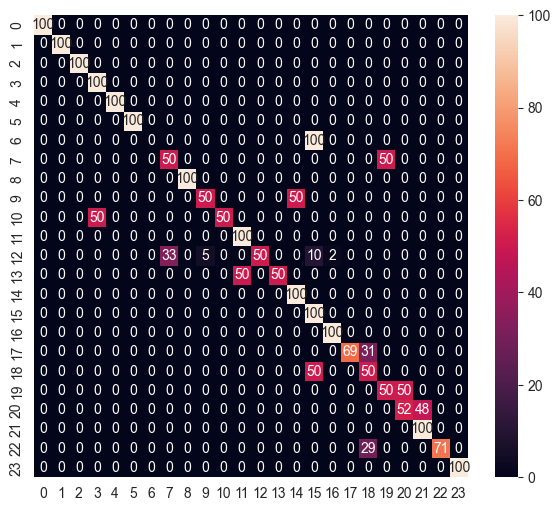

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100
           2       1.00      1.00      1.00       100
           3       0.67      1.00      0.80       100
           4       1.00      1.00      1.00       100
           5       1.00      1.00      1.00       100
           6       0.00      0.00      0.00       100
           7       0.60      0.50      0.55       100
           8       1.00      1.00      1.00       100
           9       0.91      0.50      0.65       100
          10       1.00      0.50      0.67       100
          11       0.67      1.00      0.80       100
          12       1.00      0.50      0.67       100
          13       1.00      0.50      0.67       100
          14       0.67      1.00      0.80       100
          15       0.38      1.00      0.56       100
          16       0.98      1.00      0.99       100
     

C:\gesture_recognition_by_image\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\gesture_recognition_by_image\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\gesture_recognition_by_image\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()

    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

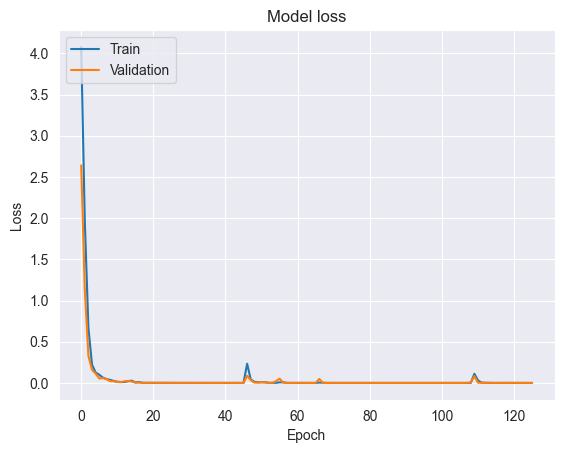

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

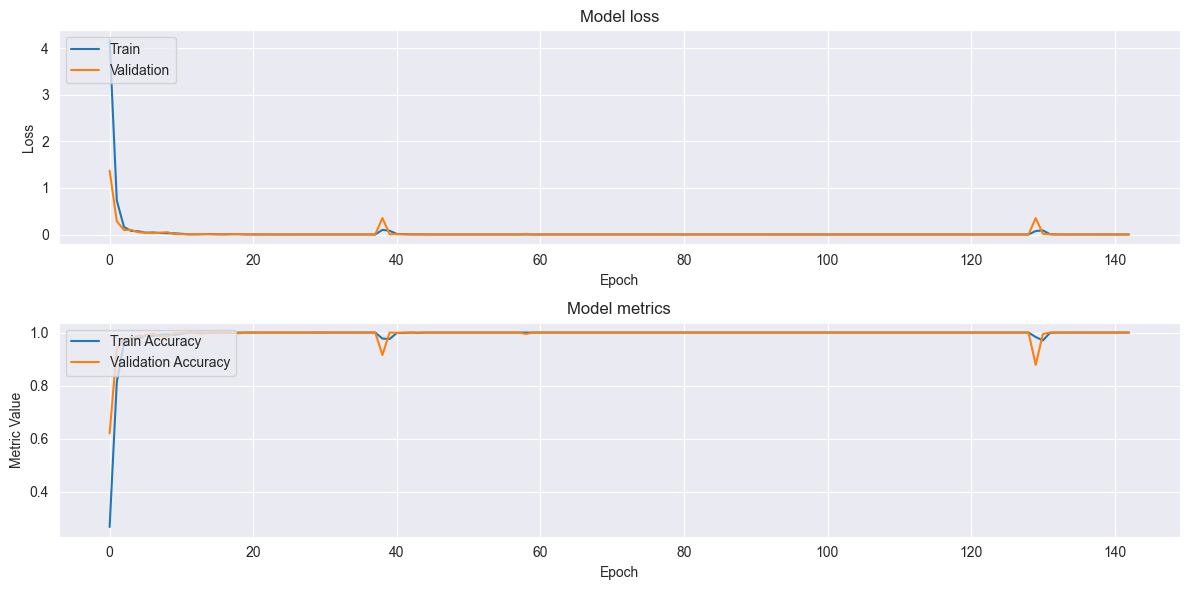

In [33]:
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy and F1 score values
plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model metrics')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'F1 Score'], loc='upper left')

plt.tight_layout()
plt.show()